In [29]:
from torch.utils.data import Dataset
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import torch
import random
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from random import randint
from augment_functions import (
    random_mask,
    resize_encoder,
    augment_sample,
    augment_sample_random_mask,
)
from sklearn.metrics.pairwise import pairwise_distances

In [30]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)

In [31]:
def random_mask(sample, mask_prob=0.7):
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image


class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        masked_x_0_5 = random_mask(x, mask_prob=0.5)
        masked_x_0_3 = random_mask(x, mask_prob=0.3)
        y = idx
        return x_orig, x, masked_x, masked_x_0_3, masked_x_0_5, y

In [32]:
model = torch.load(
    "simclr_decoder.pth", weights_only=False, map_location=DEVICE
)
model.eval()

model = model.model.encoder

model_orig = torch.load(
    "simclr_decoder.pth", weights_only=False, map_location=DEVICE
)
model_orig.eval()

model_orig = model_orig.model.encoder

BATCH_SIZE = 20
data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
test_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g
)

In [33]:
def negative_cosine_sim_matrix(embeddings):
    z = F.normalize(embeddings, dim=1)
    sim_matrix = torch.matmul(z, z.T)
    N = sim_matrix.shape[0]
    mask = ~torch.eye(N, dtype=torch.bool, device=sim_matrix.device)
    negative_sims = sim_matrix[mask]
    return negative_sims

In [34]:
cos_sim_mean = []
rand_cos_sim_mean = []
mean_var = []
with torch.no_grad():
    for batch in testloader:
        X = batch[1].to(DEVICE)
        X_prime = batch[2].to(DEVICE)
        embeddings_x, _ = model(X)
        embeddings_x_prime, _ = model(X_prime)

        embeddings_x = embeddings_x.cpu()
        embeddings_x_prime = embeddings_x_prime.cpu()

        cos_sim = F.cosine_similarity(embeddings_x, embeddings_x_prime, dim=1)
        cos_sim_mean.append(cos_sim.mean().item())

        neg_cosine = negative_cosine_sim_matrix(embeddings_x)
        rand_cos_sim_mean.append(neg_cosine.mean().item())

        variance = embeddings_x.var(dim=0)
        mean_var.append(variance.mean().item())

cos_sim, rand_cos_sim, mean_var = (
    np.mean(cos_sim_mean),
    np.mean(rand_cos_sim_mean),
    np.mean(mean_var),
)

print("Mean Cosine similarity:", cos_sim)
print("Negative Mean Cosine similarity:", rand_cos_sim)
print("Mean Variance of Embeddings", mean_var)

Mean Cosine similarity: 0.9359039516530485
Negative Mean Cosine similarity: 0.0791652490440597
Mean Variance of Embeddings 0.005054196301035774


In [35]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([20, 5, 144, 72])


In [36]:
with torch.no_grad():
    embeddings_x, _ = model(x)
    embeddings_masked_x, _ = model(masked_x)
    embeddings_masked_x_0_3, _ = model(masked_x_0_3)
    embeddings_masked_x_0_5, _ = model(masked_x_0_5)

    embeddings_x_orig, _ = model_orig(x)
    embeddings_masked_x_orig, _ = model_orig(masked_x)
    embeddings_masked_x_0_3_orig, _ = model_orig(masked_x_0_3)
    embeddings_masked_x_0_5_orig, _ = model_orig(masked_x_0_5)

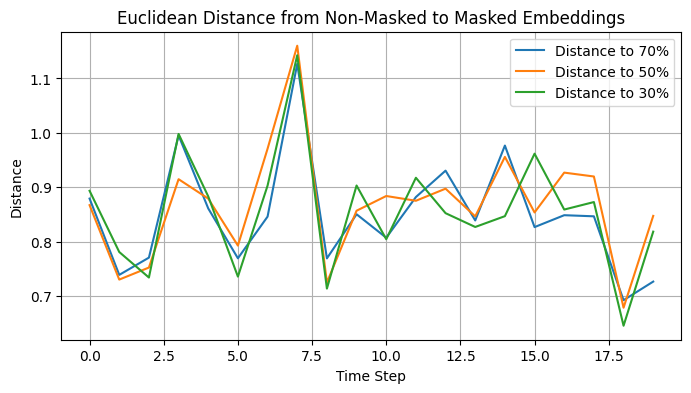

In [37]:
embeddings_x = embeddings_x.cpu()
embeddings_masked_x = embeddings_masked_x.cpu()
embeddings_masked_x_0_5 = embeddings_masked_x_0_5.cpu()
embeddings_masked_x_0_3 = embeddings_masked_x_0_3.cpu()
dist = np.linalg.norm(embeddings_x - embeddings_masked_x, axis=1)
dist2 = np.linalg.norm(embeddings_x - embeddings_masked_x_0_5, axis=1)
dist1 = np.linalg.norm(embeddings_x - embeddings_masked_x_0_3, axis=1)
plt.figure(figsize=(8, 4))
plt.plot(dist, label="Distance to 70%")
plt.plot(dist2, label="Distance to 50%")
plt.plot(dist1, label="Distance to 30%")
plt.title(f"Euclidean Distance from Non-Masked to Masked Embeddings")
plt.xlabel("Time Step")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
plt.show()

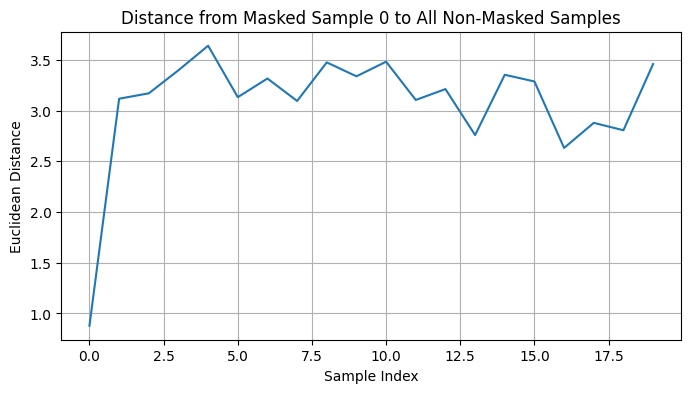

In [38]:
ref_embedding = embeddings_masked_x[0]  # shape: (embedding_dim,)
dist_to_all = np.linalg.norm(embeddings_x - ref_embedding, axis=1)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(dist_to_all)
plt.title("Distance from Masked Sample 0 to All Non-Masked Samples")
plt.xlabel("Sample Index")
plt.ylabel("Euclidean Distance")
plt.grid(True)
plt.show()

In [39]:
embeddings_x = embeddings_x.cpu().numpy()
embeddings_masked_x = embeddings_masked_x.cpu().numpy()
embeddings_masked_x_0_3 = embeddings_masked_x_0_3.cpu().numpy()
embeddings_masked_x_0_5 = embeddings_masked_x_0_5.cpu().numpy()
y = y.cpu().numpy()

combined = np.vstack(
    [
        embeddings_x,
        embeddings_masked_x,
        embeddings_masked_x_0_3,
        embeddings_masked_x_0_5,
    ]
)
pca = PCA(n_components=2)
combined_proj = pca.fit_transform(combined)

x_proj = combined_proj[: len(embeddings_x)]
x_prime_proj = combined_proj[len(embeddings_x) : len(embeddings_x) * 2]
x_prime_proj_0_3 = combined_proj[
    len(embeddings_x) * 2 : len(embeddings_x) * 3
]
x_prime_proj_0_5 = combined_proj[
    len(embeddings_x) * 3 : len(embeddings_x) * 4
]

In [40]:
df = pd.DataFrame(
    {
        "x": np.concatenate(
            [
                x_proj[:, 0],
                x_prime_proj_0_3[:, 0],
                x_prime_proj_0_5[:, 0],
                x_prime_proj[:, 0],
            ]
        ),
        "y": np.concatenate(
            [
                x_proj[:, 1],
                x_prime_proj_0_3[:, 1],
                x_prime_proj_0_5[:, 1],
                x_prime_proj[:, 1],
            ]
        ),
        "group": ["No Mask"] * BATCH_SIZE
        + ["30% Mask"] * BATCH_SIZE
        + ["50% Mask"] * BATCH_SIZE
        + ["70% Mask"] * BATCH_SIZE,
        "point_id": list(range(BATCH_SIZE)) * 4,
        "labels": list(y) * 4,
    }
)

/tmp/ipykernel_3378255/1970368293.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_labels))


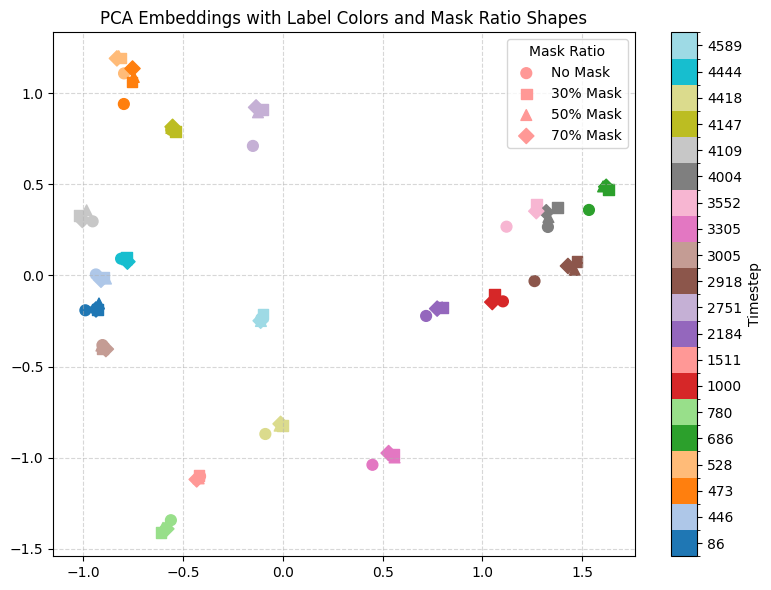

In [41]:
unique_labels = sorted(df["labels"].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
df["label_int"] = df["labels"].map(label_to_int)

cmap = plt.cm.get_cmap("tab20", len(unique_labels))
norm = mcolors.BoundaryNorm(
    np.arange(-0.5, len(unique_labels) + 0.5), len(unique_labels)
)


markers = {"No Mask": "o", "30% Mask": "s", "50% Mask": "^", "70% Mask": "D"}

plt.figure(figsize=(8, 6))

for group, marker in markers.items():
    group_data = df[df["group"] == group]
    plt.scatter(
        group_data["x"],
        group_data["y"],
        c=group_data["label_int"],
        cmap=cmap,
        norm=norm,
        marker=marker,
        s=60,
        label=f"{group}",
    )

cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.set_label("Timestep")
cbar.ax.set_yticklabels(unique_labels)

plt.title("PCA Embeddings with Label Colors and Mask Ratio Shapes")
plt.legend(title="Mask Ratio")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [42]:
BATCH_SIZE = 256
data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
test_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([256, 5, 144, 72])


In [44]:
with torch.no_grad():
    embeddings_masked_x, _ = model(masked_x)
embeddings_masked_x = embeddings_masked_x.cpu()

In [45]:
embeddings_masked_x_np = embeddings_masked_x.cpu().numpy()
y = y.cpu().numpy()

pca = PCA(n_components=2)
x_proj = pca.fit_transform(embeddings_masked_x_np)

In [46]:
df = pd.DataFrame({"x": x_proj[:, 0], "y": x_proj[:, 1], "labels": y})

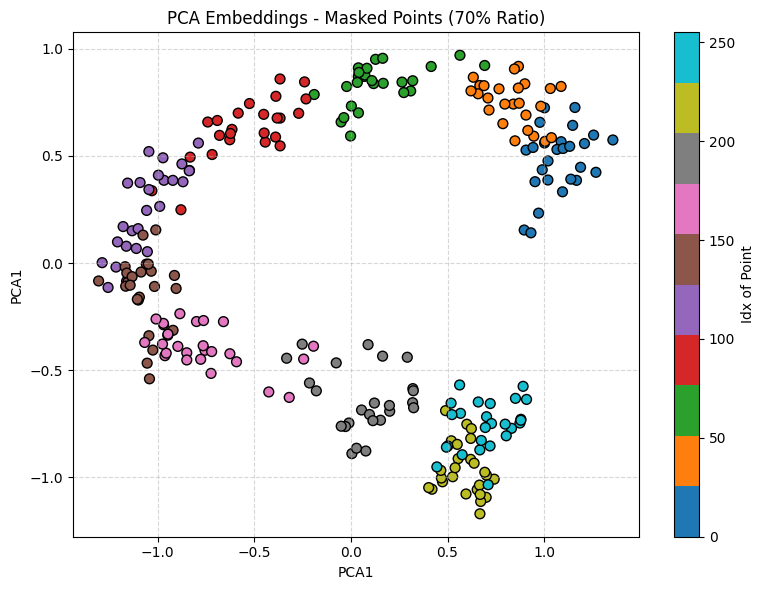

In [47]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["x"], df["y"], c=df["labels"], cmap="tab10", s=50, edgecolors="k"
)
plt.xlabel("PCA1")
plt.ylabel("PCA1")
plt.title("PCA Embeddings - Masked Points (70% Ratio)")
plt.colorbar(scatter, label="Idx of Point")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

import numpy as np

range_k = [4, 8, 12, 16, 24, 32]
nmi_scores = []
for k in range_k:
    temp_labels = np.arange(BATCH_SIZE) // (BATCH_SIZE // k)
    clust_labels = KMeans(n_clusters=k).fit_predict(embeddings_masked_x_np)
    nmi_scores.append(normalized_mutual_info_score(temp_labels, clust_labels))

print(nmi_scores)

[np.float64(0.6616424647717798), np.float64(0.6680150186954648), np.float64(0.7471092970022978), np.float64(0.7915516007823195), np.float64(0.7844244516054343), np.float64(0.8121001122583464)]


In [49]:
cosine_sims = [
    F.cosine_similarity(
        embeddings_masked_x[i + 1], embeddings_masked_x[i], dim=0
    )
    .cpu()
    .numpy()
    for i in range(len(embeddings_masked_x) - 1)
]
print(f"Mean Cosine Similarity: {np.mean(cosine_sims):.4f}")
print(f"Variance of Cosine Similarity: {np.var(cosine_sims):.4f}")
print(
    f"Coefficient of Variation of Cosine Similarity: {np.std(cosine_sims)/np.mean(cosine_sims):.4f}"
)
cosine_sims = np.array(cosine_sims)
rms_d = np.sqrt(np.mean(cosine_sims**2))
print(f"RMS: {rms_d:.4f}")

Mean Cosine Similarity: 0.7837
Variance of Cosine Similarity: 0.0020
Coefficient of Variation of Cosine Similarity: 0.0574
RMS: 0.7850


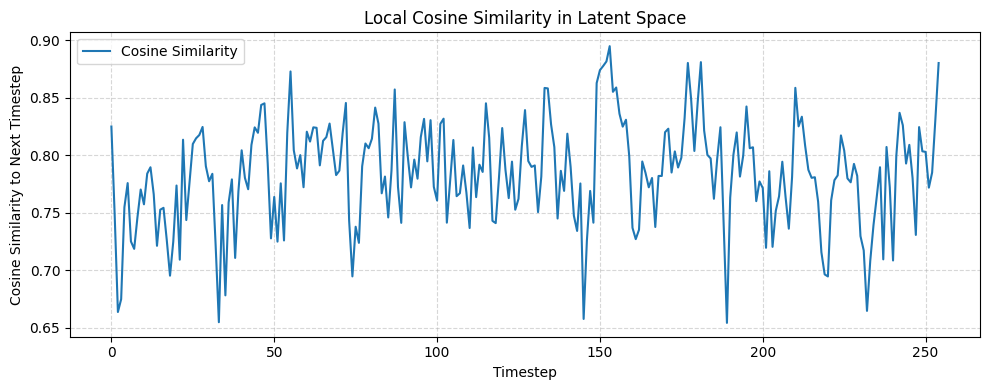

In [50]:
plt.figure(figsize=(10, 4))
plt.plot(cosine_sims, label="Cosine Similarity")
plt.xlabel("Timestep")
plt.ylabel("Cosine Similarity to Next Timestep")
plt.title("Local Cosine Similarity in Latent Space")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
step_dists = [
    np.linalg.norm(embeddings_masked_x_np[i + 1] - embeddings_masked_x_np[i])
    ** 2
    for i in range(len(embeddings_masked_x_np) - 1)
]
print(f"Mean of Step Distances: {np.mean(step_dists):.4f}")
print(f"Variance of Step Distances: {np.var(step_dists):.4f}")
print(
    f"Coefficient of Variation of Step Distances: {np.std(step_dists)/np.mean(step_dists):.4f}"
)
step_dists = np.array(step_dists)
rms_d = np.sqrt(np.mean(step_dists**2))
print(f"RMS step‐length: {rms_d:.4f}")

Mean of Step Distances: 2.5269
Variance of Step Distances: 0.2940
Coefficient of Variation of Step Distances: 0.2146
RMS step‐length: 2.5844


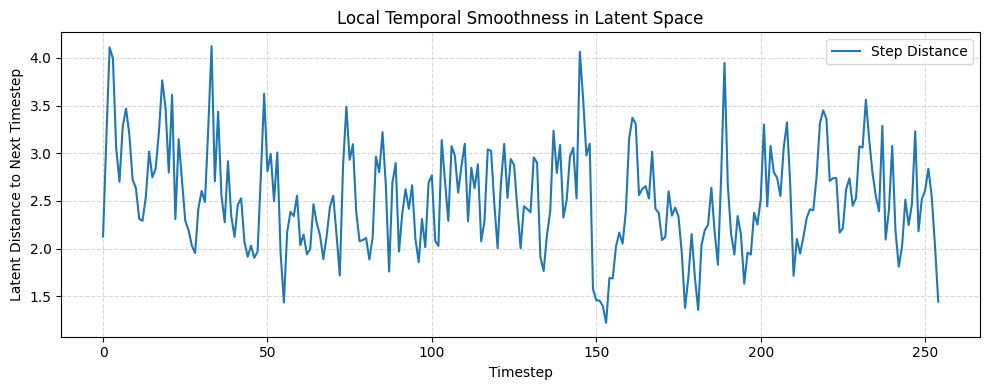

In [52]:
plt.figure(figsize=(10, 4))
plt.plot(step_dists, label="Step Distance")
plt.xlabel("Timestep")
plt.ylabel("Latent Distance to Next Timestep")
plt.title("Local Temporal Smoothness in Latent Space")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
cycle_dists = [
    np.linalg.norm(
        embeddings_masked_x_np[i + 1]
        - 2 * embeddings_masked_x_np[i]
        + embeddings_masked_x_np[i - 1]
    )
    ** 2
    for i in range(1, len(embeddings_masked_x_np) - 1)
]
print("Mean Cycle Distances:", np.mean(cycle_dists))
print(f"Variance of Cycle Distances: {np.var(cycle_dists):.4f}")
print(
    f"Coefficient of Variation of Cycle Distances: {np.std(cycle_dists)/np.mean(cycle_dists):.4f}"
)
cycle_dists = np.array(cycle_dists)
rms_d = np.sqrt(np.mean(cycle_dists**2))
print(f"RMS: {rms_d:.4f}")

Mean Cycle Distances: 5.4450045
Variance of Cycle Distances: 1.7897
Coefficient of Variation of Cycle Distances: 0.2457
RMS: 5.6069


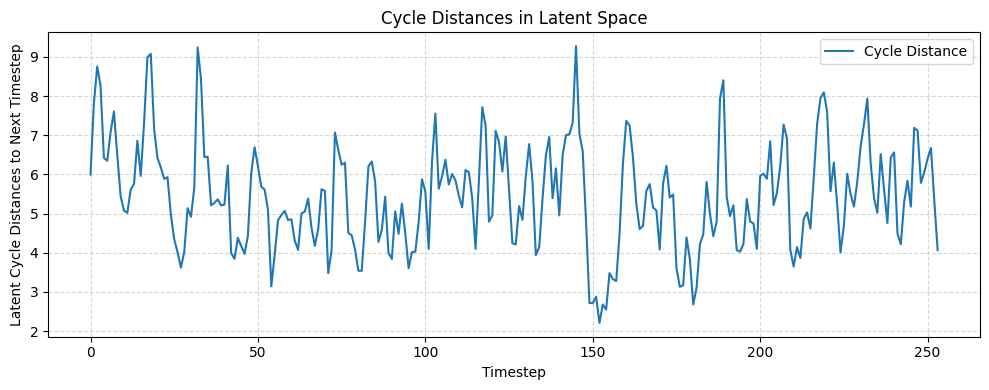

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(cycle_dists, label="Cycle Distance")
plt.xlabel("Timestep")
plt.ylabel("Latent Cycle Distances to Next Timestep")
plt.title("Cycle Distances in Latent Space")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
step_series = pd.Series(step_dists)
autocorr = step_series.autocorr(lag=1)
print(f"Autocorrelation of step distances (lag=1): {autocorr:.3f}")

Autocorrelation of step distances (lag=1): 0.543


In [56]:
# Train a neural ODE
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from neural_ode.neural_ode_model import (
    NeuralODE,
    LatentTestDataset,
    train_neural_ode,
)

# Encode the data
encoded_data_list = []
with torch.no_grad():
    for batch in testloader:
        masked_x = batch[2].to(DEVICE)
        encoded_data, _ = model(masked_x)
        encoded_data_list.append(encoded_data)

encoded_data_list = torch.cat(encoded_data_list, dim=0)

encoded_dataset = LatentTestDataset(
    data=encoded_data_list, context_length=BATCH_SIZE, stride=1
)
encoded_dataloder = DataLoader(
    encoded_dataset, batch_size=BATCH_SIZE, shuffle=True
)

neural_model = NeuralODE(dim=encoded_data_list.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(neural_model.parameters(), lr=1e-2)
loss_fn = torch.nn.MSELoss()

# neural_model = train_neural_ode(
#     10,
#     model=neural_model,
#     trainloader=encoded_dataloder,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     device=DEVICE,
# )
# torch.save(neural_model, "neural_ode.pth")

In [57]:
neural_model = torch.load(
    "neural_ode.pth", weights_only=False, map_location=DEVICE
)

In [58]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([256, 5, 144, 72])


In [59]:
with torch.no_grad():
    embeddings_masked_x, _ = model(masked_x)
# embeddings_masked_x =embeddings_masked_x.cpu()

In [60]:
odefunc = neural_model.odefunc
odefunc.eval()
speeds = []

z_seq = embeddings_masked_x
t_seq = torch.linspace(0, 1, steps=z_seq.shape[0]).to(z_seq.device)

speeds = odefunc(t_seq, z_seq.unsqueeze(0)).squeeze(0)
speeds = speeds.norm(dim=1) ** 2

print(f"Speed Mean: {speeds.mean()}")
print(f"Speed Variance: {speeds.var()}")
print(f"Coefficient of Variation of Speed: {speeds.std()/speeds.mean():.4f}")
rms_d = torch.sqrt((speeds**2).mean())
print(f"RMS: {rms_d:.4f}")

speeds = speeds.detach().cpu().numpy()

Speed Mean: 24.49319076538086
Speed Variance: 67.41548919677734
Coefficient of Variation of Speed: 0.3352
RMS: 25.8277


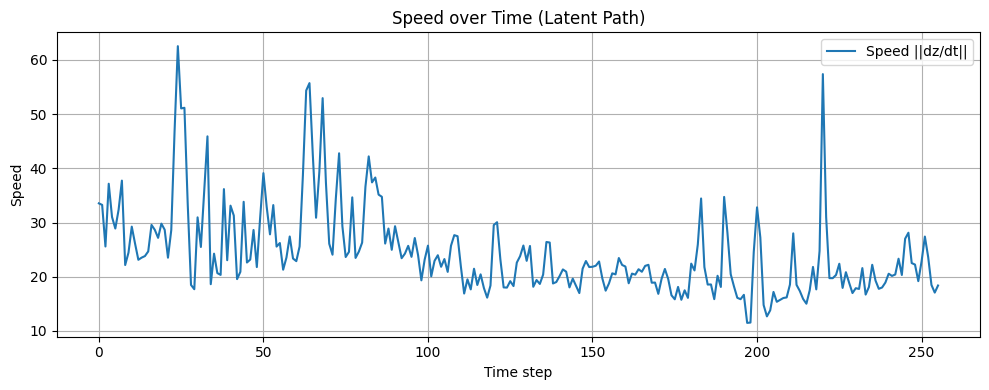

In [61]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(BATCH_SIZE), speeds, label="Speed ||dz/dt||")
plt.xlabel("Time step")
plt.ylabel("Speed")
plt.title("Speed over Time (Latent Path)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
t_seq = t_seq.clone().detach().requires_grad_()
z_seq = z_seq.clone().detach()
f_seq = odefunc(t_seq, z_seq.unsqueeze(0)).squeeze(0)  # [T, D]
d3_list = []
d2_list = []
for j in range(f_seq.size(1)):
    # second derivative
    d2f_j = torch.autograd.grad(
        outputs=f_seq[:, j],
        inputs=t_seq,
        grad_outputs=torch.ones_like(t_seq),
        retain_graph=True,
        create_graph=True,
    )[0]
    d2_list.append(d2f_j)
    # third derivative
    d3f_j = torch.autograd.grad(
        outputs=d2f_j,
        inputs=t_seq,
        grad_outputs=torch.ones_like(d2f_j),
        create_graph=True,
    )[0]

    d3_list.append(d3f_j)

d2 = torch.stack(d2_list, dim=1)  # [T, D]
d3 = torch.stack(d3_list, dim=1)  # [T, D]

curvatures = (d2.norm(dim=1) ** 2).detach().cpu().numpy()  # [T]
jerk = (d3.norm(dim=1) ** 2).detach().cpu().numpy()  # [T]

In [63]:
print(f"Mean curvatures: {curvatures.mean()}")
print(f"Variance of curvatures: {curvatures.var()}")
print(
    f"Coefficient of Variation of curvatures: {curvatures.std()/curvatures.mean():.4f}"
)
rms_d = np.sqrt((curvatures**2).mean())
print(f"RMS: {rms_d:.4f}")

Mean curvatures: 0.7421016693115234
Variance of curvatures: 0.10332033038139343
Coefficient of Variation of curvatures: 0.4331
RMS: 0.8087


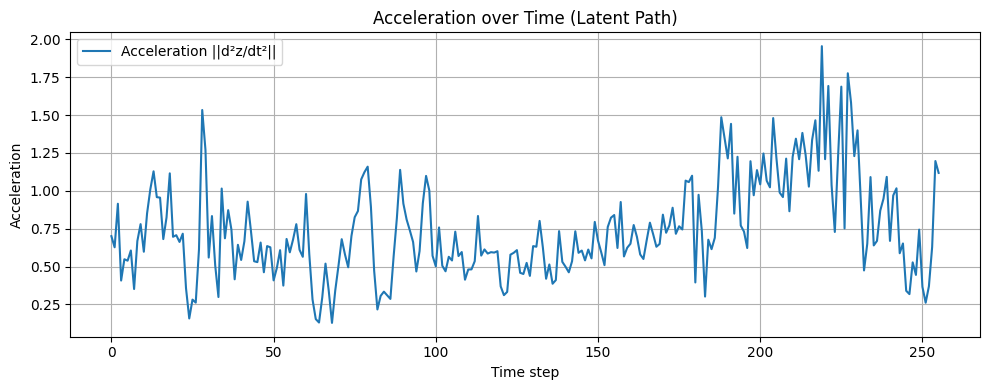

In [64]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(BATCH_SIZE), curvatures, label="Acceleration ||d²z/dt²||")
plt.xlabel("Time step")
plt.ylabel("Acceleration")
plt.title("Acceleration over Time (Latent Path)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
print(f"Mean jerk: {jerk.mean()}")
print(f"Variance of jerk: {jerk.var()}")
print(f"Coefficient of Variation of jerk: {jerk.std()/jerk.mean():.4f}")
rms_d = np.sqrt((jerk**2).mean())
print(f"RMS: {rms_d:.4f}")

Mean jerk: 0.01957380399107933
Variance of jerk: 0.00015192150021903217
Coefficient of Variation of jerk: 0.6297
RMS: 0.0231


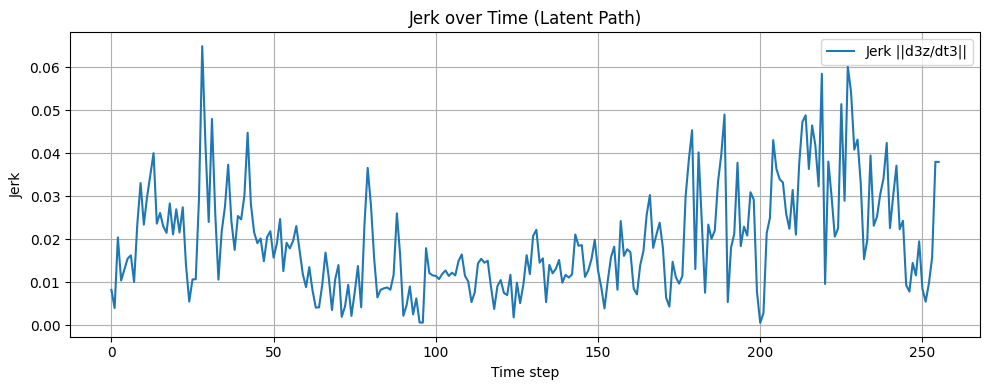

In [66]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(BATCH_SIZE), jerk, label="Jerk ||d3z/dt3||")
plt.xlabel("Time step")
plt.ylabel("Jerk")
plt.title("Jerk over Time (Latent Path)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
# Smoothness Metrics: https://www.researchgate.net/publication/375512061_Trade-offs_in_the_latent_representation_of_microstructure_evolution

V = encoded_data_list[1:] - encoded_data_list[:-1]
S = torch.sign(V)
same_sign = (S[1:] == S[:-1]).float()
C_t = same_sign.mean(dim=1)
M1 = C_t.mean()


v1 = V[:-1]
v2 = V[1:]
cos_sim = F.cosine_similarity(v1, v2, dim=1)
cos_sim = torch.clamp(cos_sim, -1.0, 1.0)
alpha_t = torch.acos(cos_sim)
M2 = alpha_t.mean()

In [ ]:
print(f"Metric 1: {M1.item()}")
print(f"Metric 2: {M2.item()}")

Metric 1: 0.4806922674179077
Metric 2: 1.6267844438552856


: 